# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: MAX

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
# from sklearn.dummy import DummyClassifier
# random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
# y_random = random_classifier.predict_proba(X_test)[:,1]
# y_random

y_random = np.random.uniform(0, 1, X_test.shape[0])
y_random

array([0.3318043 , 0.00948513, 0.98358309, ..., 0.5701824 , 0.2848773 ,
       0.62434111])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Ну потому что predict_proba а не predic - это вероятности, а не классы.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [4]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay


import plotly.graph_objects as go
from sklearn.metrics import roc_curve
from plotly.subplots import make_subplots

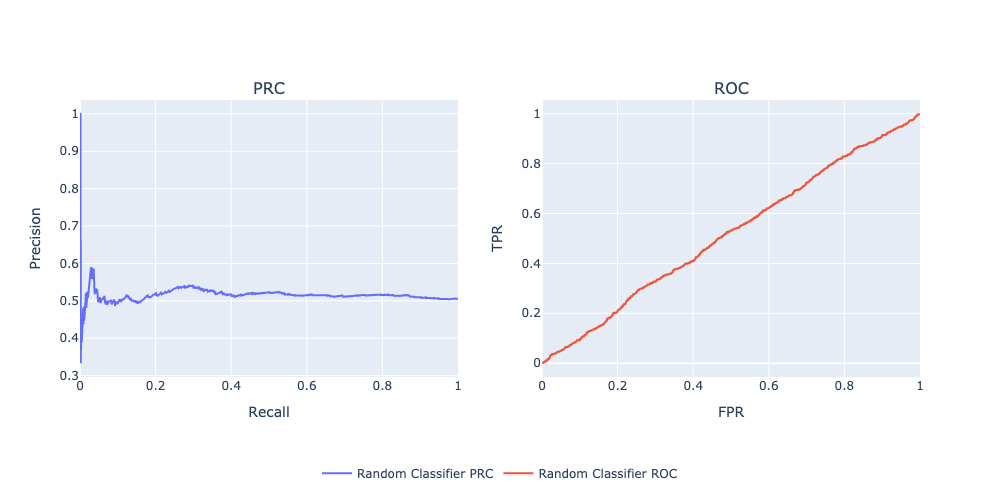

In [5]:
# def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
#     if ax is None:
#         fig, ax = plt.subplots(1, 2, figsize=(11, 5))

#     print(classifier_name, 'metrics')
#     PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
#     print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
#     ax[0].set_title("PRC")
#     ax[0].set_ylim(0, 1.1)

#     RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
#     print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
#     ax[1].set_title("ROC")
#     ax[1].set_ylim(0, 1.1)

#     plt.tight_layout()
#     plt.legend()

def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', fig=None, return_fig=False):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)

    if fig is None:
        fig = make_subplots(
            rows=1, cols=2,
            subplot_titles=[f'PRC', f'ROC'],
            shared_yaxes=False
        )

    fig.add_trace(go.Scatter(x=recall, y=precision, mode='lines', name=f'{classifier_name} PRC'),
                  row=1, col=1)

    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'{classifier_name} ROC'),
                  row=1, col=2)

    fig.update_layout(
        xaxis_title='Recall',
        yaxis_title='Precision',
        xaxis2_title='FPR',
        yaxis2_title='TPR',
        height=500,
        width=1000,
        
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=-0.4,
            xanchor='center',
            x=0.5
        )
    )

    if return_fig:
        return fig
    
    fig.show(renderer='png')

    
depict_pr_roc(y_test, y_random, 'Random Classifier')

In [6]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.516363,0.517255,0.0


## Дисклемер

Я данные не предобрабатываю так как мне не сказали (МООООООП), ну и в целом пофиг на синтетическом датасете

__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [7]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore")

model = LinearSVC()

param_grid = {'C': np.logspace(-3, 3, 7)}

# грид серч внутри использует кроссвалидацию
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=make_scorer(average_precision_score))
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'C': 0.001}

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

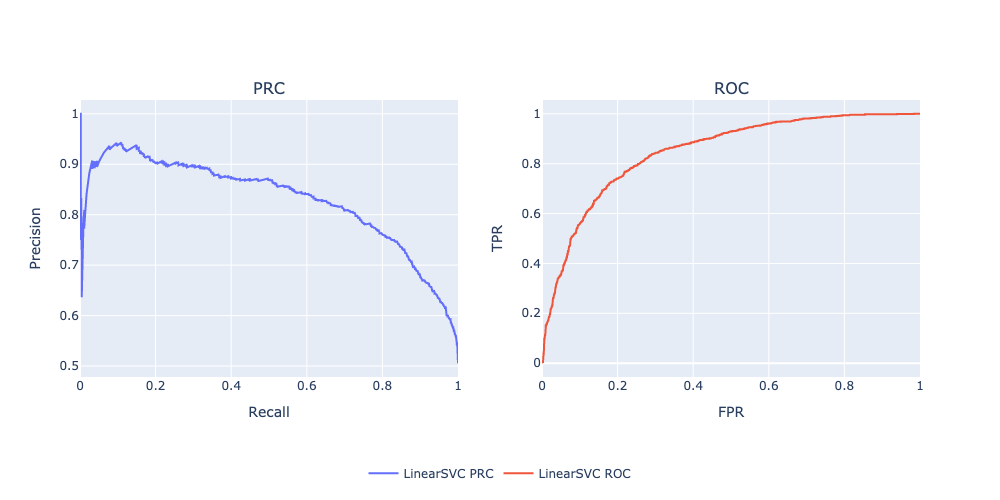

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.516363,0.517255,0.000
LinearSVC,0.829550,0.847418,0.001


In [8]:
model = LinearSVC(C=0.001)
y_linear = model.fit(X_train, y_train).decision_function(X_test)

df_metrics.loc['LinearSVC'] = [
      average_precision_score(y_test, y_linear),
      roc_auc_score(y_test, y_linear),
      0.001,
]

depict_pr_roc(y_test, y_linear, 'LinearSVC')
df_metrics

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

**Ответ:**

При увеличении порога точность растет, а полнота падает, так как модель становится более строгой в классификации положительных примеров. 

ROC кривая всегада монотонна. PRC не монотонна - ну понятно, сразу мы очень уверены и можем увеличивать как Precision так и Recall, а потом уже приходится жертвовать Precision ради увеличения Recall.

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

**Ответ:**

Тупой вопрос. Мы лучше случайного классификатора, как удивительно (МОООООООП)

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [9]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

param_grid = {'C': np.logspace(-3, 3, 7)}

# грид серч внутри использует кроссвалидацию
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=make_scorer(average_precision_score))
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'C': 0.01}

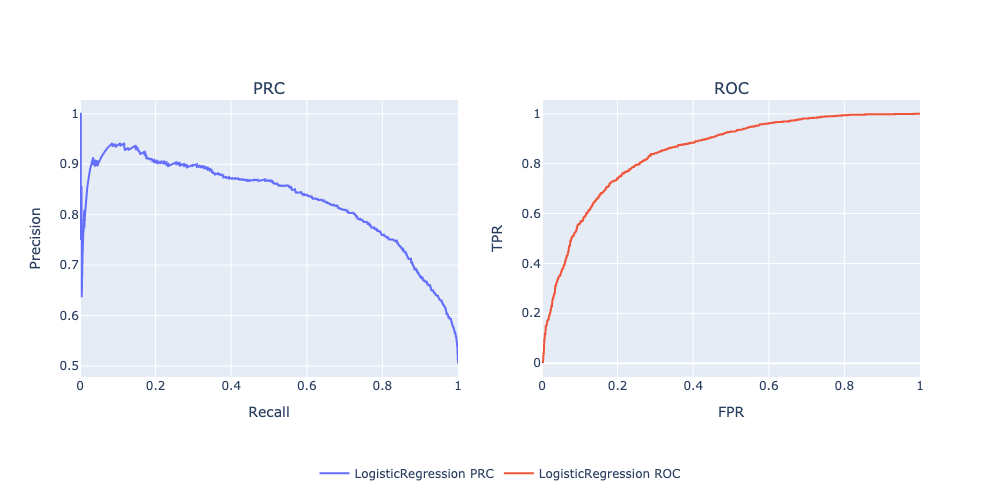

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.516363,0.517255,0.000
LinearSVC,0.829550,0.847418,0.001
LogisticRegression,0.829933,0.847587,0.010


In [10]:
model = LogisticRegression(C=0.01)
y_logreg = model.fit(X_train, y_train).predict_proba(X_test)[:,1]

df_metrics.loc['LogisticRegression'] = [
      average_precision_score(y_test, y_logreg),
      roc_auc_score(y_test, y_logreg),
      0.01,
]

depict_pr_roc(y_test, y_logreg, 'LogisticRegression')
df_metrics

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

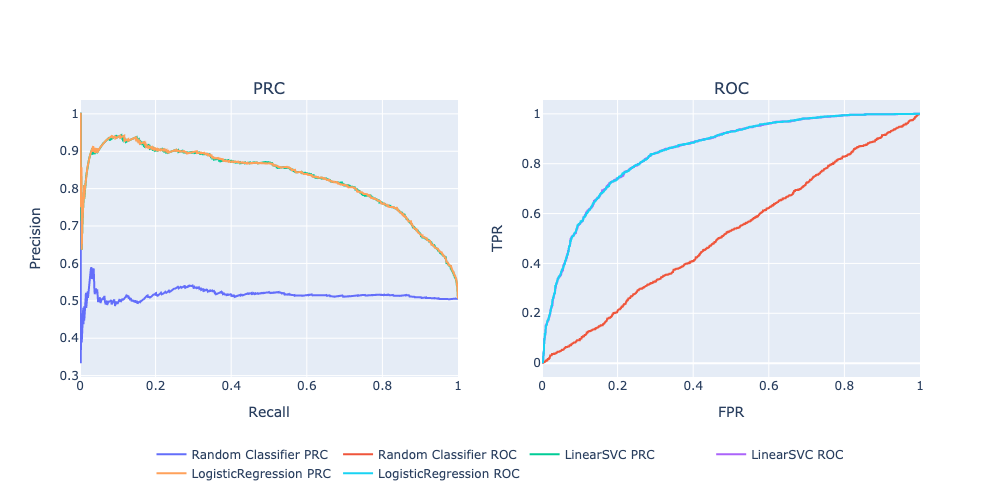

In [11]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=[f'PRC', f'ROC'],
    shared_yaxes=False
)

depict_pr_roc(y_test, y_random, 'Random Classifier', fig, True)
depict_pr_roc(y_test, y_linear, 'LinearSVC', fig, True)
depict_pr_roc(y_test, y_logreg, 'LogisticRegression', fig)

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:**

Они совпадают, ну в целом неудивительно, так как задачка совсем простая.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [12]:
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, random_state=12)

model = LinearSVC(C=0.01).fit(X, y)

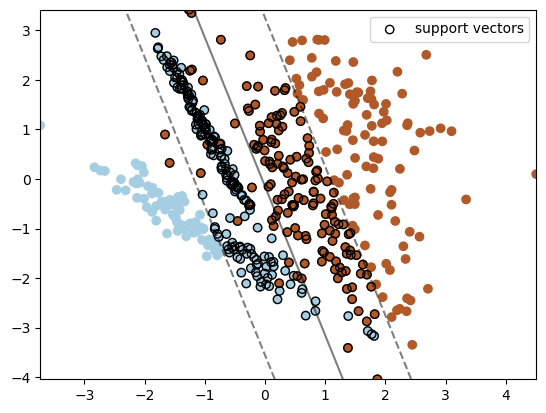

In [13]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy)
    Z = Z.reshape(XX.shape)    
    
    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    
    plt.scatter(
        X[:, 0], X[:, 1],
        c=y,
        cmap=plt.cm.Paired
    )
    
    # Отрисовали опорные векторы
    if plot_support:
        
        decision_values = model.decision_function(X)
        y = np.where(y == 0, -1, 1) # SLT наконец-то пригодилась
        
        margin_threshold = 1e-3
        support_vector_indices = y * decision_values <= 1 + margin_threshold
                    
        plt.scatter(
            X[support_vector_indices, 0], X[support_vector_indices, 1],
            label='support vectors',
            linewidth=1,
            edgecolor="black",
            facecolors='none'
        )

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Те объекты, на которых функция потель в SVM ненулевая.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [14]:
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, random_state=12)

model = LogisticRegression(C=0.01).fit(X, y)

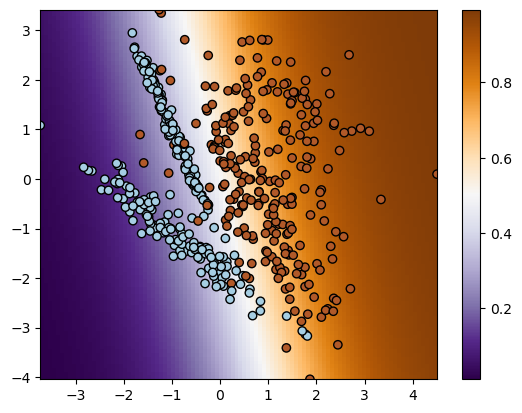

In [15]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    Z = model.predict_proba(xy)[:,1]
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    plt.scatter(
        X[:, 0], X[:, 1],
        c=y,
        cmap=plt.cm.Paired,
        edgecolor="black",
    )

    plt.colorbar(image)

plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Очередной тупой вопрос. Модель неуверена, вероятности 50%, что? что тут хотят?

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [16]:
def plot_calibration_curve(y_test, preds, name):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)        
        bin_middle_points.append((l + r) / 2) 
        
        ones = (y_test[(preds >= l) & (preds < r)] == 1)
        
        bin_real_ratios.append(ones.sum() / len(ones))
        
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios, label=name)
    plt.plot([0, 1], [0, 1], label='Ideal model')
    plt.ylim([-0.05, 1.05])
    plt.legend()
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

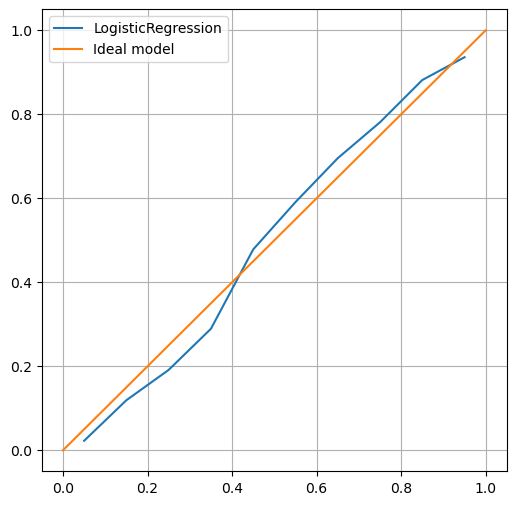

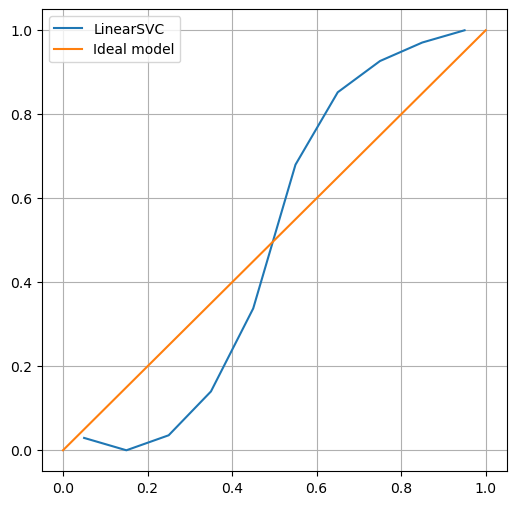

In [17]:
from scipy.special import expit

X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

proba = LogisticRegression(C=0.01).fit(X_train, y_train).predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, proba, "LogisticRegression")

sudo_proba = expit(LinearSVC(C=0.01).fit(X_train, y_train).decision_function(X_test))
plot_calibration_curve(y_test, sudo_proba, "LinearSVC")

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** 

`LinearSVC` очень плохо - это не задача этого классификатора. `LogisticRegression` - достаточно хорошо, при увеличении $n$ и однородности теста с трейном он сойдется к `Idel model`

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [18]:
from sklearn.metrics import log_loss, brier_score_loss

proba = LogisticRegression(C=0.01).fit(X_train, y_train).predict_proba(X_test)[:, 1]

print(f"LogLoss for LogisticRegression: {log_loss(y_test, proba)}")
print(f"BrierScore for LogisticRegression: {brier_score_loss(y_test, proba)}\n")

sudo_proba = expit(LinearSVC(C=0.01).fit(X_train, y_train).decision_function(X_test))

print(f"LogLoss for LinearSVC: {log_loss(y_test, sudo_proba)}")
print(f"BrierScore for LinearSVC: {brier_score_loss(y_test, sudo_proba)}")

LogLoss for LogisticRegression: 0.39636629383891403
BrierScore for LogisticRegression: 0.12495840894149543

LogLoss for LinearSVC: 0.49027358445756863
BrierScore for LinearSVC: 0.15617664721742155


Изучите распределение ответов классификаторов при помощи гистограмм

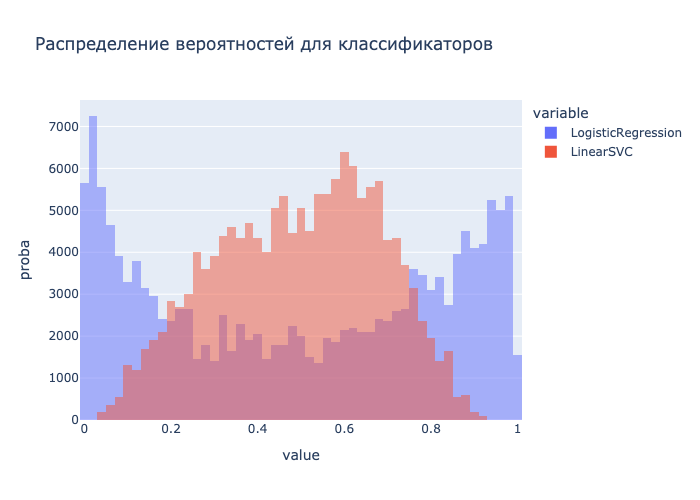

In [19]:
import plotly.express as px

df = pd.DataFrame({
    'LogisticRegression': proba,
    'LinearSVC': sudo_proba
})

px.histogram(
    df, 
    x=["LogisticRegression", "LinearSVC"], 
    title="Распределение вероятностей для классификаторов", 
    barmode='overlay', 
    histnorm='density'
).update_yaxes(title='proba').show(renderer='png')

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** 

У `LinearSVC` нет экстремальных значений уверенности - нет стимула повышать значение decision_function если объект уже и так классифицируется корректно. С другой стороны `LogisticRegression` будет стараться сделать вероятности бризкими к $0$ или $1$ для объектов, в которых он очень уверен - это заложено в его функции потерь. 

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

LogLoss for LinearSVC Calibrated: 0.3954564276721853
BrierScore for LinearSVC Calibrated: 0.12464974647179486


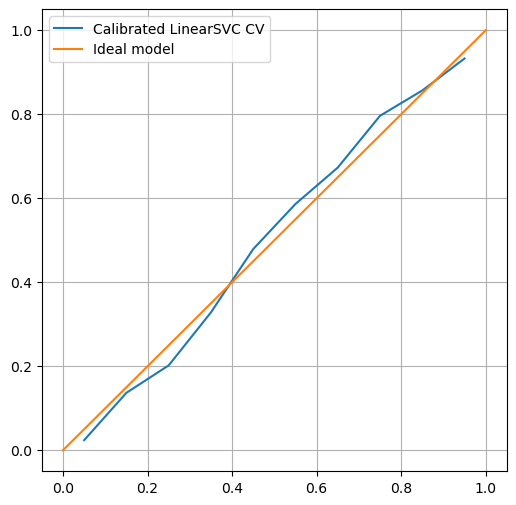

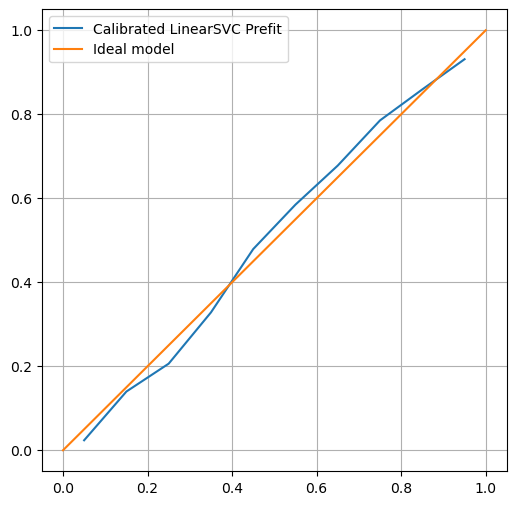

In [20]:
from sklearn.calibration import CalibratedClassifierCV

model = LinearSVC(C=0.01)
model = CalibratedClassifierCV(model).fit(X_train, y_train)
sudo_proba_calibrated =  model.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, sudo_proba_calibrated, "Calibrated LinearSVC CV")

model = LinearSVC(C=0.01).fit(X_train, y_train)
model = CalibratedClassifierCV(model, cv="prefit").fit(X_train, y_train)
sudo_proba_calibrated_prefit =  model.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, sudo_proba_calibrated_prefit, "Calibrated LinearSVC Prefit")

print(f"LogLoss for LinearSVC Calibrated: {log_loss(y_test, sudo_proba_calibrated)}")
print(f"BrierScore for LinearSVC Calibrated: {brier_score_loss(y_test, sudo_proba_calibrated)}")

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Да.

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

Использую Platt Scaling, применяя логистическую регрессию к исходным предсказанным вероятностям.

LogLoss for LinearSVC Platt: 0.40663343861878776
BrierScore for LinearSVC Platt: 0.12789588590375842


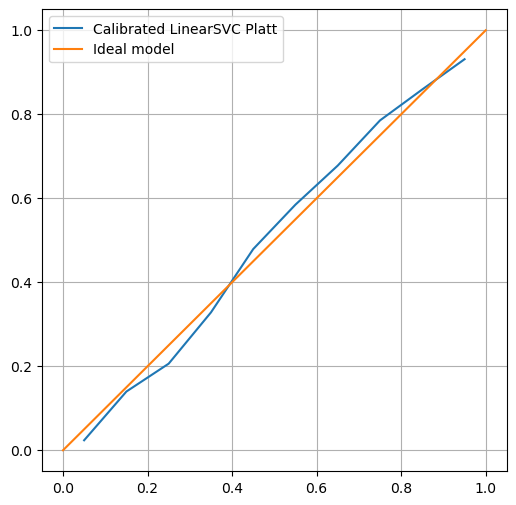

In [21]:
model = LinearSVC(C=0.01).fit(X_train, y_train)
sudo_proba_train = model.decision_function(X_train).reshape(-1, 1)
sudo_proba_test = model.decision_function(X_test).reshape(-1, 1)

mode_refitted = LogisticRegression(C=0.01).fit(sudo_proba_train, y_train)
proba = mode_refitted.predict_proba(sudo_proba_test)[:, 1]

plot_calibration_curve(y_test, sudo_proba_calibrated_prefit, "Calibrated LinearSVC Platt")

print(f"LogLoss for LinearSVC Platt: {log_loss(y_test, proba)}")
print(f"BrierScore for LinearSVC Platt: {brier_score_loss(y_test, proba)}")

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [22]:
import kagglehub  

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [23]:
data = pd.read_csv(path)
data.sample(3)

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
24,27184,Single,Male,40000.0,2.0,Partial College,Clerical,No,1.0,0-1 Miles,Europe,34.0,No
208,22633,Single,Female,40000.0,0.0,Graduate Degree,Clerical,Yes,0.0,0-1 Miles,Europe,37.0,Yes
615,11538,Single,Female,60000.0,4.0,Graduate Degree,Skilled Manual,No,NaN,0-1 Miles,North America,47.0,Yes


In [24]:
NUMERICAL = ["Income", "Children", "Cars", "Age"]

CATEGORICAL = ["Marital Status", "Gender", "Education", "Occupation", \
                 "Home Owner", "Commute Distance", "Region"]

for col in CATEGORICAL:
    data[col].fillna("undefined", inplace=True)

y = data['Purchased Bike']
X_numerical = data[NUMERICAL]
X_categorical = data[CATEGORICAL]

In [25]:
y.value_counts()

Purchased Bike
No     519
Yes    481
Name: count, dtype: int64

In [26]:
y = np.where(y == "Yes", 1, 0)

В начале поработаем только с категориальными признаками

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

In [28]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def get_model(encoder):
    column_transformer = ColumnTransformer(
        transformers = [
            ('cat', encoder, CATEGORICAL)
        ]
    )

    model = Pipeline(
        steps = [
            ('transformer', column_transformer),
            ('model', LogisticRegression())
        ]
    )
    
    return model

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [29]:
encoder = OrdinalEncoder()

%time proba = get_model(encoder).fit(X_train, y_train).predict_proba(X_test)[:, 1]

CPU times: user 4.7 ms, sys: 820 µs, total: 5.52 ms
Wall time: 4.88 ms


In [30]:
average_precision_score(y_test, proba)

0.5883009320176316

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [31]:
encoder = OneHotEncoder()

%time proba = get_model(encoder).fit(X_train, y_train).predict_proba(X_test)[:, 1]

CPU times: user 6.98 ms, sys: 785 µs, total: 7.77 ms
Wall time: 7.16 ms


In [32]:
average_precision_score(y_test, proba)

0.666642757355176

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.means_ = {}

    def fit(self, X, y):
        X_df = pd.DataFrame(X)
        columns = X.columns
        
        X_df['y'] = y     
                
        for col in columns:
            self.means_[col] = X_df.groupby(col)['y'].mean().to_dict()
            
        return self

    def transform(self, X):

        X_encoded = X.copy()
        
        for col in X.columns:
            X_encoded[col] = X[col].map(self.means_.get(col, None))
            
        return X_encoded

In [34]:
encoder = MeanTargetEncoder()

%time proba = get_model(encoder).fit(X_train, y_train).predict_proba(X_test)[:, 1]

CPU times: user 5.61 ms, sys: 552 µs, total: 6.16 ms
Wall time: 5.7 ms


In [35]:
average_precision_score(y_test, proba)

0.6575408792625901

Вышло быстрее так как меньше фичей обучать надо.

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [36]:
# Ой, я даже не видел этого до того как уже все сделал пунктом выше

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [37]:
class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, var=0.01):
        self.means_ = {}
        self.var = var

    def fit(self, X, y):
        X_df = pd.DataFrame(X)
        columns = X.columns
        
        X_df['y'] = y        
                
        for col in columns:
            means = X_df.groupby(col)['y'].mean().to_dict()
            self.means_[col] = {k: v + np.random.normal(0, self.var) for k, v in means.items()}
            
        return self

    def transform(self, X):

        X_encoded = X.copy()
        
        for col in X.columns:
            X_encoded[col] = X[col].map(self.means_.get(col, None))
            
        return X_encoded

In [38]:
encoder = MeanTargetEncoder(var=0)
model = get_model(encoder).fit(X_train, y_train)

proba_test = model.predict_proba(X_test)[:, 1]
proba_train = model.predict_proba(X_train)[:, 1]

print(f"APS on test: {average_precision_score(y_test, proba_test)}")
print(f"APS on train: {average_precision_score(y_train, proba_train)}")

APS on test: 0.6575408792625901
APS on train: 0.6332213874196568


In [39]:
encoder = MeanTargetEncoder(var=0.01)
model = get_model(encoder).fit(X_train, y_train)

proba_test = model.predict_proba(X_test)[:, 1]
proba_train = model.predict_proba(X_train)[:, 1]

print(f"APS on test: {average_precision_score(y_test, proba_test)}")
print(f"APS on train: {average_precision_score(y_train, proba_train)}")

APS on test: 0.6692092003899852
APS on train: 0.6372301013450947


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** В среднем не помогает, хз почему

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [40]:
# скиииип

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [41]:
class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, C=10):
        self.means_ = {}
        self.C = C

    def fit(self, X, y):
        X_df = pd.DataFrame(X)
        columns = X.columns
        
        X_df['y'] = y    
        
        M = np.mean(y)
                
        for col in columns:            
            grouped = X_df.groupby(col)['y'].agg(['sum', 'count'])
            means = ((grouped['sum'] + self.C * M) / (grouped['count'] + self.C)).to_dict()
            self.means_[col] = means
            
        return self

    def transform(self, X):

        X_encoded = X.copy()
        
        for col in X.columns:
            X_encoded[col] = X[col].map(self.means_.get(col, None))
            
        return X_encoded

In [42]:
param_grid = {
    'transformer__cat__C': np.linspace(0, 20, num=40)
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring=make_scorer(average_precision_score))


encoder = MeanTargetEncoder()
model = get_model(encoder)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring=make_scorer(average_precision_score))
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'transformer__cat__C': 16.41025641025641}

In [43]:
encoder = MeanTargetEncoder(16.4)
model = get_model(encoder).fit(X_train, y_train)
    
proba_test = model.predict_proba(X_test)[:, 1]
average_precision_score(y_test, proba_test)

0.6695265235888657

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [44]:
# устал макакингом заниматься

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [45]:
# устал макакингом заниматься

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

In [46]:
data = pd.read_csv(path)
for col in CATEGORICAL:
    data[col].fillna("undefined", inplace=True)

y = data['Purchased Bike']
y = np.where(y == "Yes", 1, 0)
X = data[NUMERICAL + CATEGORICAL]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), CATEGORICAL),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), NUMERICAL),
    ]
)

model = Pipeline(
    steps = [
        ('transformer', column_transformer),
        ('model', LogisticRegression())
    ]
)

proba_test = model.fit(X_train, y_train).predict_proba(X_test)[:, 1]
average_precision_score(y_test, proba_test)

0.702305000440103



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Склонны к переобучению, имеют большую дисперсию. Могут давать совсем немного лучший скор, экономят время обочения и память в сравнении с `OneHotEncoder`.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [47]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-11-28 22:11:12--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data.5’

adult.data.5            [        <=>         ]   3.79M  79.8KB/s    in 35s     

2024-11-28 22:11:49 (111 KB/s) - ‘adult.data.5’ saved [3974305]



In [48]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
14040,40,Federal-gov,219240,HS-grad,9,Divorced,Adm-clerical,Unmarried,White,Female,0,0,22,United-States,0
11686,22,Self-emp-inc,375422,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Male,0,0,40,South,0
20041,30,Private,189759,Bachelors,13,Never-married,Sales,Not-in-family,White,Male,0,0,40,United-States,0
12391,35,Local-gov,103966,Masters,14,Divorced,Adm-clerical,Unmarried,White,Female,0,0,41,United-States,0
23894,46,Private,228372,Bachelors,13,Divorced,Sales,Unmarried,White,Male,0,0,40,United-States,1


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [49]:
y = df['income']
X = df.drop(columns=['income'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [50]:
X_train.shape[1]

14

In [51]:
CATEGORICAL = ['workclass', 'education', 'education-num', \
               'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

NUMERICAL = ['fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']

column_transformer = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(), CATEGORICAL),
        ('num', StandardScaler(), NUMERICAL),
    ]
)

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

In [52]:
X_train.shape[1]

122

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [53]:
model = LogisticRegression().fit(X_train, y_train)

proba_test = model.predict_proba(X_test)[:, 1]
average_precision_score(y_test, proba_test)

0.7623245319683142

Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [54]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, \
                                                  test_size=0.33, random_state=777, stratify=y_train)

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [55]:
def foo(X_train, X_val, y_train, y_val):
    model = LogisticRegression(random_state=43).fit(X_train, y_train)
    proba_val = model.predict_proba(X_val)[:, 1]
    print(f"APS all features: {average_precision_score(y_val, proba_val)}")

    coefficients = np.abs(model.coef_[0])
    top_features = np.argsort(coefficients)[-40:]

    X_train_reduced = X_train[:, top_features]
    X_val_reduced = X_val[:, top_features]
    
    model = LogisticRegression(random_state=43).fit(X_train_reduced, y_train)
    proba_val = model.predict_proba(X_val_reduced)[:, 1]
    print(f"APS best 40 features: {average_precision_score(y_val, proba_val)}\n")
    
%time foo(X_train, X_val, y_train, y_val)

APS all features: 0.7598557449534609
APS best 40 features: 0.6806162317037819

CPU times: user 75.9 ms, sys: 1.71 ms, total: 77.6 ms
Wall time: 77 ms


Изменилось ли качество? Как?

**Ответ:**

Сильно упало.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

<span style="color:red">Как же достало что нас принимают за идиотов которые даже признаки не могут отмасштабировать, ну я понимаю во втором дз, ну в третьем (хотя там составители и сами не смогли обойтись без train on the test), ну сколько можно правда.</span>

## Откатываю масштабирование

In [56]:
df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

y = df['income']
X = df.drop(columns=['income'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

column_transformer = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(), CATEGORICAL),
#         ('num', StandardScaler(), NUMERICAL),
    ]
)

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, \
                                                  test_size=0.33, random_state=777, stratify=y_train)

In [57]:
%time foo(X_train, X_val, y_train, y_val)

APS all features: 0.6800065820971163
APS best 40 features: 0.6217652119301991

CPU times: user 73.4 ms, sys: 1.43 ms, total: 74.9 ms
Wall time: 74.1 ms


**Ответ:**

Вышла `*****`

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [58]:
df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

y = df['income']
X = df.drop(columns=['income'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), CATEGORICAL),
        ('num', 'passthrough', NUMERICAL)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('scaler', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, \
                                                  test_size=0.33, random_state=777, stratify=y_train)

In [59]:
%time foo(X_train, X_val, y_train, y_val)

APS all features: 0.7585742798463506
APS best 40 features: 0.7482294879454741

CPU times: user 1.61 s, sys: 244 ms, total: 1.86 s
Wall time: 172 ms


Я уж было снова хотел пожаловаться на тупое задние а тут такое, ладно, круто. В целом понятно что отобрались другие фичи и поэтому скор сильно лучше на `best 40 features`, но все же я за почти год работы в скоринге про это не думал даже как-то.

## Возвращает все как было

In [60]:
df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

y = df['income']
X = df.drop(columns=['income'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

column_transformer = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(), CATEGORICAL),
        ('num', StandardScaler(), NUMERICAL),
    ]
)

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, \
                                                  test_size=0.33, random_state=777, stratify=y_train)

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** 

Буквально корреляция пирсона говорит о линейной зависимости между фичами и таргетом. Очев как отбирать, брать самые высокоскореллированные с таргетом.


Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора

In [61]:
def bar1():
    correlations = [np.corrcoef(X_train[:, i].toarray().ravel(), y_train)[0, 1] for i in range(X_train.shape[1])]
    top_features = np.argsort(np.abs(correlations))[-40:]

    model = LogisticRegression(random_state=41).fit(X_train[:, top_features], y_train)
    proba_val = model.predict_proba(X_val[:, top_features])[:, 1]
    print(f"APS: {average_precision_score(y_val, proba_val)}\n")
    
%time bar1()

APS: 0.7458290874831542

CPU times: user 209 ms, sys: 1.33 s, total: 1.54 s
Wall time: 139 ms


В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [62]:
def bar2():
    pos = X_train[y_train == 1].todense()
    neg = X_train[y_train == 0].todense()
        
    n_pos = pos.shape[0]
    n_neg = neg.shape[0]
    
    num = np.abs(pos.mean(axis=0) - neg.mean(axis=0))
    denum = np.sqrt((n_pos * pos.var(axis=0) + n_neg * neg.var(axis=0)) / (n_pos + n_neg))
    
    top_features = np.argsort(np.asarray(num / denum).ravel())[-40:]
        
    model = LogisticRegression(random_state=41).fit(X_train[:, top_features], y_train)
    proba_val = model.predict_proba(X_val[:, top_features])[:, 1]
    print(f"APS: {average_precision_score(y_val, proba_val)}\n")

    
%time bar2()

APS: 0.7458290874831542

CPU times: user 51.5 ms, sys: 3.58 ms, total: 55 ms
Wall time: 54.4 ms


Прикольно, нам очень повезло и оба метода отобрали
одинаковые фичи.

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [63]:
from tqdm.notebook import tqdm

def backward_step(X_train, X_val, y_train, y_val, features, n_to_drop):
    scores = {}
    
    for feature in features:
        features_m = [f for f in features if f != feature]
        model = LogisticRegression(random_state=43).fit(X_train[:, features_m], y_train)
        proba_val = model.predict_proba(X_val[:, features_m])[:, 1]
        scores[feature] = average_precision_score(y_val, proba_val)
    
    sorted_features = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    features_to_drop = [feature for feature, score in sorted_features[:n_to_drop]]
    
    remaining_features = [f for f in features if f not in features_to_drop]
    return remaining_features

def backward(_train, X_val, y_train, y_val, features, n_to_drop, n):
    for i in tqdm(range(0, len(features) - n, n_to_drop)):
        features = backward_step(X_train, X_val, y_train, y_val, features, 1)
        
    return features

In [64]:
features = np.arange(X_train.shape[1])
%time features = backward(X_train, X_val, y_train, y_val, features, 1, 40)

  0%|          | 0/82 [00:00<?, ?it/s]

CPU times: user 5min 22s, sys: 2.4 s, total: 5min 24s
Wall time: 5min 24s


In [65]:
model = LogisticRegression(random_state=43).fit(X_train[:, features], y_train)
proba_val = model.predict_proba(X_val[:, features])[:, 1]
average_precision_score(y_val, proba_val)

0.7605661490605483

In [66]:
len(features)

40

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [67]:
def forward_step(X_train, X_val, y_train, y_val, base_features, features):
    scores = {}
    
    for feature in features:
        features_m = base_features + [feature]
        model = LogisticRegression(random_state=43).fit(X_train[:, features_m], y_train)
        proba_val = model.predict_proba(X_val[:, features_m])[:, 1]
        scores[feature] = average_precision_score(y_val, proba_val)
    
    best_feature = max(scores, key=scores.get)
    
    return base_features + [best_feature]

def forward(_train, X_val, y_train, y_val, features, n):
    base_features = []
    
    for i in tqdm(range(0, n)):
        base_features = forward_step(X_train, X_val, y_train, y_val, base_features, features)
        
    return base_features

In [68]:
features = np.arange(X_train.shape[1])
%time features = forward(X_train, X_val, y_train, y_val, features, 40)

  0%|          | 0/40 [00:00<?, ?it/s]

CPU times: user 1min 57s, sys: 435 ms, total: 1min 58s
Wall time: 1min 58s


In [69]:
model = LogisticRegression(random_state=43).fit(X_train[:, features], y_train)
proba_val = model.predict_proba(X_val[:, features])[:, 1]
average_precision_score(y_val, proba_val)

0.7608166026091004

In [70]:
len(features)

40

Да, последние признаки ухудшают качество модели.

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Примерно одинаковы. Через `backward` лучше убрать несколько фичей из модели, а через `forward` добавлять фичи. 

# Часть 4. Оценка экономического эффекта модели (2 балла)



# Скип, скучно, сразу бонус

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [88]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [89]:
df.head()

In [90]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [91]:
from collections import defaultdict
from sklearn.model_selection import KFold

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        # your code here

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            # "metric_key": metric_value
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [92]:
# your code here

Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [93]:
# your code here

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [94]:
# your code here

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [95]:
# your code here

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [96]:
# your code here

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [97]:
# your code here

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




In [98]:
# your code here

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ # your answer here

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [99]:
# your code here

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [203]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [204]:
data = pd.read_csv(path)
data[[target] + features].isna().any()

Target               False
Marital status       False
Course               False
Nacionality          False
Gender               False
Age at enrollment    False
dtype: bool

In [205]:
y = OrdinalEncoder().fit_transform(data[['Target']])
X = data[features]
X

,Marital status,Course,Nacionality,Gender,Age at enrollment
0,1,2,1,1,20
1,1,11,1,1,19
2,1,5,1,1,19
3,1,15,1,0,20
4,2,3,1,0,45
...,...,...,...,...,...
4419,1,15,1,1,19
4420,1,15,19,0,18
4421,1,12,1,0,30
4422,1,9,1,0,20


In [206]:
NUMERIC = ['Course', 'Age at enrollment']
CATEGORICAL = ['Marital status', 'Nacionality', 'Gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

In [207]:
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist'), CATEGORICAL),
        ('num', StandardScaler(), NUMERIC)
    ]
)

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [208]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

In [209]:
%time model = OneVsRestClassifier(LogisticRegression(max_iter=10000, random_state=42))
probas_ovr = model.fit(X_train, y_train).predict_proba(X_test)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 9.06 µs


In [210]:
%time model = OneVsOneClassifier(LogisticRegression(max_iter=10000, random_state=42))
probas_ovo = model.fit(X_train, y_train).decision_function(X_test)

CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 17.2 µs


In [211]:
pd.DataFrame(y_train).value_counts()

2.0    1768
0.0    1134
1.0     637
Name: count, dtype: int64

In [212]:
from sklearn.metrics import precision_score

precision_score(y_test, np.argmax(probas_ovo, axis=1), average='macro')

0.37965403868368824

In [213]:
precision_score(y_test, np.argmax(probas_ovr, axis=1), average='macro')

0.37390947568454697

Как вы объясните полученные результаты?

__Ответ:__ 

В целом точность у нас низкая так как мы используем мало не самых информативных фичей.

В `OneVsRestClassifier` классификаторов $C$, и скорость обучения линейна по количеству классов. В `OneVsOneClassifier` классификаторов $C(С-1)/2$, и скорость обучения квадратична по количеству классов, он дает немного лучше качество.

Почему выбрал precision? Хотим точно определять числанется студент или нет чтобы не тратить время военкома, который лично придет его поздравить, но при этом нам важно еще знать вдруг он уже закончил университет и можно прийти к нему без торта с пирожными. Почему macro? Хотим чтобы все классы имели равный вклад.


#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [218]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
from scipy.special import softmax, log_softmax
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
        
    log_probs = log_softmax(y_pred, axis=1)

    masked_log_probs = log_probs[np.arange(y_true.shape[0]), y_true]    
    
    return  -np.mean(masked_log_probs)

In [219]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

Я делал все это на ГО, там очень страшные выкладки так то техать не буду тут.

In [220]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    logits = X @ W.T
    probs = softmax(logits, axis=1)
    probs[np.arange(y.shape[0]), y] -= 1
    grad = (probs) / y.shape[0]
    return grad.T @ X

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [261]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        self.W = np.random.normal(size=(len(np.unique(y)), X.shape[1]))

        for _ in tqdm(range(self.max_iter)):
            grad = ce_gradient(X, self.W, y)
            self.W -= self.lr * grad
            
        return self

    def predict(self, X, y=None):
        logits = X @ self.W.T
        return softmax(logits, axis=1)

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [264]:
model = SoftmaxRegression(max_iter=3000)

pred = model.fit(X_train, y_train.astype(int)).predict(X_test)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [265]:
precision_score(y_test, np.argmax(pred, axis=1), average='macro')

0.2538795055198253

__Ответ__:

Ну неплохо, не я недообучисля

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ Пармизан